# Dataset Generation
#### G08: Mina Faghih, Zahra Sadat Jamadi, Milad Heshmati and Mehran Attar

##### COMP 6321: Machine Learning Project Report

##### Concordia University

Creating the dataset for M-PSK Modulation Wireless Network
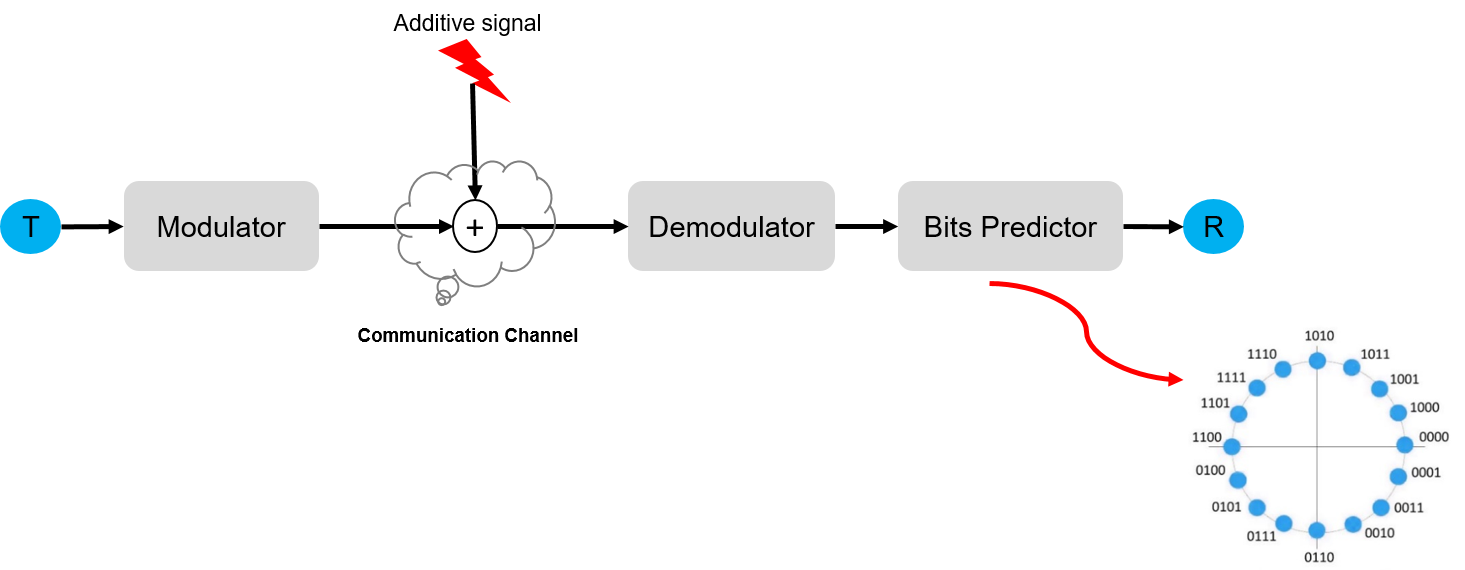

Importing required packages 

In [1]:
from IPython.display import Image
import numpy as np
import math
import cmath
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Generating Bits

Data bits consisting of zeros (0) and ones (1) are generated randomly in This section. The value <strong>N</strong> is selected as a multiplication of 64 which is the highest constellation size considered in this project

In [2]:
#Number of bits:
N = 3000*int(1)

#Generating Random Sequence of bits:
bit_seq = np.random.randint(2, size=(N,)) #Bit Sequence

print(bit_seq)
print(bit_seq.shape)

[0 1 1 ... 0 1 0]
(3000,)


# Impelementing M-PSK modulation

Next, we are going to select and apply a M-PSK modulation to the generated bit sequence.

## Symbol reshaping 

As forst stage, we should split the bit sequence into groups in order to be considered as symbols:

In [3]:
#Constelarion Size:
M = 8

#Devision Factor (number of bits in each symbol):
Dev_fac = int(math.log2(M))

sym_bits = bit_seq.reshape((int(N/Dev_fac),Dev_fac))
print(sym_bits)

[[0 1 1]
 [0 1 1]
 [0 0 1]
 ...
 [0 0 0]
 [0 1 1]
 [0 1 0]]


## Introducting Mapping Function

A function to map bits in symbol bits to symbol numbers. In this function grey mapping is implemented for all constellation sizes

In [4]:
def grey_mapping(sym_bits, M):
    """Returns a value for each symbol sequence which can be used for phase modulation
    
    sym_bits must refer to a ndarrays that has:
     - Dev_fac columns (length of symbol bits)
     - N/Dev_fac row (number of all symbols).
    """
    #Modulation Lookup tables:
    if (M == 2):
        code_table = np.array([[0],
                        [1]]);
    elif(M == 4):
        code_table = np.array([[0,0],
                        [0,1],
                        [1,1],
                        [1,0]]);
    elif(M == 8):
        code_table = np.array([[0,0,0],
                        [0,0,1],
                        [0,1,1],
                        [0,1,0],
                        [1,1,0],
                        [1,1,1],
                        [1,0,1],
                        [1,0,0]]);
    else:
        printf("M is not valid constellation size");

    sym_ind = np.zeros((sym_bits.shape[0],1))
    for i in range(sym_bits.shape[0]):
        for j in range(code_table.shape[0]):
            comparison = sym_bits[i,:] == code_table[j,:]
            if(comparison.all()):
                sym_ind[i]=j
    
    return sym_ind, code_table

## Phase Allocation

In this section all symbols with indexes are converted to specific phase according to the modulation size.

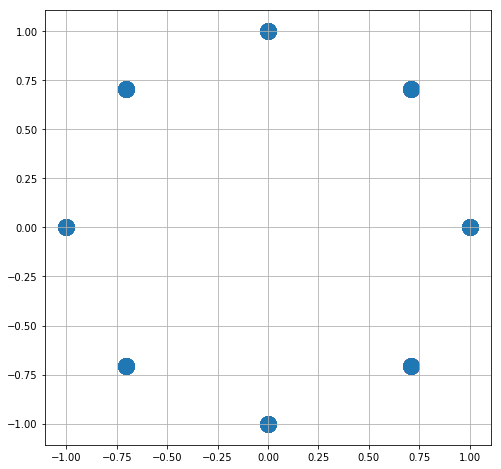

In [5]:
sym_ind,code_table = grey_mapping(sym_bits, M)
coef = ((2*math.pi)/M)*np.ones(sym_ind.shape)
data_phases = 1

C = np.multiply(coef,sym_ind)
data_phases_IM = np.sin(C)
data_phases_RE = np.cos(C)

data_phases = data_phases_RE+1j*data_phases_IM

plt.figure(figsize=(8,8))
plt.grid()
plt.scatter(data_phases_IM,data_phases_RE,linewidths=10)
plt.show()

## AWGN Noise

There is always noise in the wireless channel which affects the transmitted signals. In this section we want to simulate the noise and adding it to symbols.

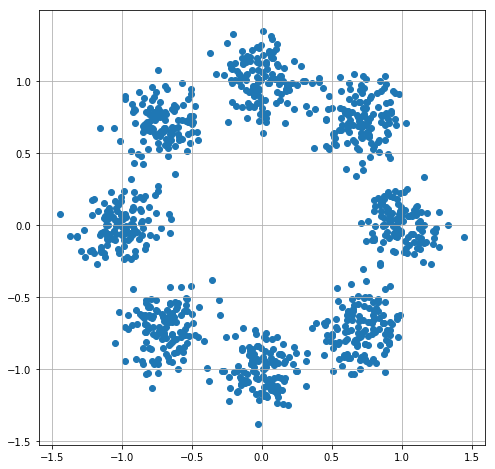

In [6]:
#Noise power:
N_0 = 0.14

#Noise vectors:
noise_IM = np.random.normal(0,N_0,data_phases_IM.shape[0])
noise_RE = np.random.normal(0,N_0,data_phases_RE.shape[0])

#Noisy signals at the receiver:
data_RX_IM = np.add( data_phases_IM[:,0], noise_IM)
data_RX_RE = np.add( data_phases_RE[:,0], noise_RE)
#data_RX_IM = data_phases_IM[:,0]
#data_RX_RE = data_phases_RE[:,0]

#Symbol Phase calculations:
C_RX = np.arctan2(data_RX_IM,data_RX_RE, out=None, where=True)* 180 / np.pi
Phase_corrector = (((-1)*np.sign(C_RX)+np.ones(C_RX.shape))/2)*360

C_RX = C_RX + Phase_corrector
C_RX = C_RX.reshape(len(C_RX), 1)

#Symbol power calculations:
P = np.square(data_RX_IM) + np.square(data_RX_IM)
P = np.sqrt(P.reshape(len(P), 1))


#SNR Calculations:
SNR = P/N_0

#Symbol Deviation Magnitude Calculation:
De_m = np.square(noise_IM) + np.square(noise_RE)
De_m = np.sqrt(De_m.reshape(len(De_m), 1))

#Symbol Deviation Angle Calculation:
De_Ang = np.arctan(noise_IM/noise_RE)
De_Ang = De_Ang.reshape(len(De_Ang), 1)


plt.figure(figsize=(8,8))
plt.grid()
plt.scatter(data_RX_RE,data_RX_IM)
plt.show()

# Data assembly

In this section the data is reshaped into regular ML format

In [7]:
X = np.stack((data_RX_RE, data_RX_IM), axis=-1)
X = np.append(X, C* 180 / np.pi , axis=1)
X = np.append(X, C_RX , axis=1)
X = np.append(X, P, axis=1)
X = np.append(X, SNR, axis=1)
X = np.append(X, De_m, axis=1)
X = np.append(X, De_Ang, axis=1)
y = sym_ind


data = np.hstack((X, y.reshape(1000,1)))
columns = ["Position: $I$", "position:$Re$",'Transmitter Phase: $T_{X}$','Receiver Phase: $R_{X}$ ',
           'Power: $P$','SNR $(dB)$','Deviation Magnitude','Deviation Angle','y']
Table = pd.DataFrame(data=data, columns=columns)
Table


,Position: $I$,position:$Re$,Transmitter Phase: $T_{X}$,Receiver Phase: $R_{X}$,Power: $P$,SNR $(dB)$,Deviation Magnitude,Deviation Angle,y
0,-0.089473,1.143705,90.0,94.473174,1.617443,11.553168,0.169283,-1.013915,2.0
1,-0.325998,1.046835,90.0,107.297256,1.480448,10.574627,0.329345,-0.142689,2.0
2,0.830200,0.579100,45.0,34.897433,0.818972,5.849797,0.177588,-0.804961,1.0
3,0.721617,1.031164,45.0,55.015355,1.458286,10.416329,0.324382,1.526049,1.0
4,1.066151,0.069476,0.0,3.728436,0.098254,0.701816,0.095932,0.809911,0.0
5,-0.583044,-0.740030,225.0,231.766650,1.046560,7.475427,0.128357,-0.259392,5.0
6,0.662036,0.846046,45.0,51.956594,1.196490,8.546356,0.146067,-1.257117,1.0
7,-1.021162,-0.192943,180.0,190.699560,0.272862,1.949014,0.194100,1.461551,4.0
8,-0.933968,0.006471,180.0,179.603057,0.009151,0.065363,0.066348,0.097680,4.0
9,-0.038954,-0.754661,270.0,267.045171,1.067252,7.623229,0.248412,-1.413336,6.0


# ML detector

In this section, traditional telecommunication Maximum Likelihood estimator is implemented

In [8]:
angle = ((2*math.pi)/M)* 180 / np.pi

lookup = np.zeros((M,2))

for i in range(M):
    min_tresh = i*angle 
    max_tresh = i*angle + angle
    lookup[i,:] = [min_tresh, max_tresh]
    
#print(lookup)  


def ML_Detector(x):
    for i in range(M):
        if (x +(angle/2) < 360):
            if (x +(angle/2) >= lookup[i,0] and x+(angle/2) <= lookup[i,1]):
                return i
        else:
            if (x +(angle/2)-360 >= lookup[i,0] and x+(angle/2)-360 <= lookup[i,1]):
                return i

sym_indx_hat = map(ML_Detector, C_RX)

# Demodulator

The detected Signals are decoded here

In [9]:
def decoder(x):
    return code_table[x,:]

bit_seq_hat = map(decoder, sym_indx_hat)
bit_seq_hat = np.reshape(list(bit_seq_hat), N)

# BER

In this section we are calculating Bit Error Rate

In [10]:
intersection_set = set.intersection(set(bit_seq), set(list(bit_seq_hat)))
bit_seq_hat = list(bit_seq_hat)

In [11]:
def BER(x, y):
    if(x == y):
        return 0
    else:
        return 1

c = map(BER, bit_seq, bit_seq_hat)
c = list(c)

print('Number of error bits: '+str(c.count(1)))
print('Bit Error Rate (BER): '+str((c.count(1)/N)*100)+' %')

Number of error bits: 4
Bit Error Rate (BER): 0.13333333333333333 %
